In [2]:
from pathlib import Path
import yaml
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import math

In [3]:
def get_indexes_with_obj_id(scene_gt, obj_id):
    indexes_by_image = {}

    for image_id, annotations in scene_gt.items():
        indexes_for_image = []
        for i, annotation in enumerate(annotations):
            if annotation['obj_id'] == str(obj_id):
                indexes_for_image.append(i)
        indexes_by_image[image_id] = indexes_for_image

    return indexes_by_image

In [4]:
def calc_metrics(output_path, scene_id, object_id, show_images=False, image_index=None):
    scene_folder_name = f"{scene_id:06d}"
    scene_path = output_path / scene_folder_name
    scene_gt_path = scene_path / "scene_gt.json"
    with open(scene_gt_path, "r") as f:
        scene_gt_json = yaml.load(f, Loader=yaml.FullLoader)

    indexes = get_indexes_with_obj_id(scene_gt_json, object_id)
    if image_index is not None:
        #set all indexes of all images to the image_index
        for image_id in indexes:
            indexes[image_id] = image_index



    metrics_per_experiment = {} 

    num_pixels_per_mask = {}
    f_score_per_mask = {}

    experiment_folders = sorted([folder for folder in output_path.iterdir() if "_" in folder.name and scene_folder_name in folder.name])
    # print(experiment_folders)
    for image_id, indexes_for_image in indexes.items():
        for index in indexes_for_image:
            mask_name = f"{int(image_id):06d}_{index:06d}.png"
            gt_mask_path = scene_path / "mask_visib" / mask_name

            # Load gt_mask 
            gt_mask = cv2.imread(str(gt_mask_path), cv2.IMREAD_GRAYSCALE)

            if show_images:
                # Calculate the number of rows and columns for the subplot grid
                num_experiments = len(experiment_folders)
                num_cols = math.ceil((num_experiments + 1) / 3)  # +1 for the ground truth mask
                num_rows = 3

                # Create a figure with subplots
                fig, axes = plt.subplots(num_rows, num_cols, figsize=(5 * num_cols, 5 * num_rows))  # Adjust figsize as needed

                # Display the ground truth mask in the first subplot
                axes[0, 0].imshow(gt_mask, cmap='gray')
                axes[0, 0].set_title('Ground Truth')
                axes[0, 0].axis('off')

            # Display experiment masks in the remaining subplots
            for i, folder in enumerate(experiment_folders):
                experiment = folder.name.split("_")[1]
                experiment_mask_path = folder / "mask_visib" / mask_name
                # Load experiment_mask
                experiment_mask = cv2.imread(str(experiment_mask_path), cv2.IMREAD_GRAYSCALE)
                if show_images:
                    row = (i + 1) // num_cols  # Calculate row index
                    col = (i + 1) % num_cols  # Calculate column index

                    axes[row, col].imshow(experiment_mask, cmap='gray')
                    axes[row, col].set_title(f'Experiment {experiment}')
                    axes[row, col].axis('off')
                if experiment not in num_pixels_per_mask:
                    num_pixels_per_mask[experiment] = []
                num_pixels_per_mask[experiment].append(np.count_nonzero(experiment_mask))

                # Calculate metrics 
                intersection = np.logical_and(gt_mask, experiment_mask)
                union = np.logical_or(gt_mask, experiment_mask)
                true_positives = np.count_nonzero(intersection)
                false_positives = np.count_nonzero(experiment_mask) - true_positives
                false_negatives = np.count_nonzero(gt_mask) - true_positives

                precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) != 0 else 0
                recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) != 0 else 0  

                f_score = 2 * precision * recall / (precision + recall) if (precision + recall) != 0 else 0
                if experiment not in f_score_per_mask:
                    f_score_per_mask[experiment] = []
                f_score_per_mask[experiment].append(f_score)

                iou = true_positives / np.count_nonzero(union) if np.count_nonzero(union) != 0 else 0

                if experiment not in metrics_per_experiment:
                    metrics_per_experiment[experiment] = {'precision': [], 'recall': [], 'iou': []}
                metrics_per_experiment[experiment]['precision'].append(precision)
                metrics_per_experiment[experiment]['recall'].append(recall)
                metrics_per_experiment[experiment]['iou'].append(iou)
            if show_images:
                plt.tight_layout()
                plt.show()


    #create a stripplot of the number of pixels per mask for each experiment using seaborn
    import seaborn as sns
    import pandas as pd

    data = pd.DataFrame(num_pixels_per_mask)
    data = data.melt(var_name='experiment', value_name='num_pixels')
    f_score_df = pd.DataFrame(f_score_per_mask)
    f_score_df = f_score_df.melt(var_name='experiment', value_name='f_score')

    data = pd.concat([data, f_score_df['f_score']], axis=1)
    data['is_red'] = data['f_score'] < 0.85
    # print(data)
    plt.figure(figsize=(15, 5))

    # Swap x and y in the stripplot call
    sns.stripplot(x='num_pixels', y='experiment', data=data, hue='is_red', jitter=0.0, dodge=True, palette={True: 'red', False: 'blue'})

    #set figure size

    plt.show()

    # Extract numeric part from keys, convert to integers, and sort
    experiment_metrics = sorted([(int(exp.lstrip('0')), metrics) for exp, metrics in metrics_per_experiment.items()])
    return experiment_metrics


def print_metrics(experiment_metrics):
    # Print metrics in sorted order
    for exp_num, metrics in experiment_metrics:
        exp_str = f"{exp_num:03d}" 
        avg_precision = sum(metrics['precision']) / len(metrics['precision'])
        avg_recall = sum(metrics['recall']) / len(metrics['recall'])
        avg_iou = sum(metrics['iou']) / len(metrics['iou'])
        print(f"Experiment: {exp_str}")
        print(f"  Average Precision: {avg_precision}")
        print(f"  Average Recall: {avg_recall}")
        print(f"  Average IoU: {avg_iou}")

def show_plot(experiment_metrics, omit_last=False):
    if omit_last:
        experiment_metrics = experiment_metrics[:-1]
    # plot experiment metrics recall precision and IoU over the experiments
    experiments = [exp_num for exp_num, _ in experiment_metrics]
    precisions = [sum(metrics['precision']) / len(metrics['precision']) for _, metrics in experiment_metrics]
    recalls = [sum(metrics['recall']) / len(metrics['recall']) for _, metrics in experiment_metrics]
    ious = [sum(metrics['iou']) / len(metrics['iou']) for _, metrics in experiment_metrics]

    plt.plot(experiments, precisions, label='Precision')
    plt.plot(experiments, recalls, label='Recall')
    plt.plot(experiments, ious, label='IoU')
    #set y axis from o to 1
    plt.ylim(0, 1)
    plt.xlabel('Experiment')
    plt.ylabel('Metric')
    plt.title('Metrics over Experiments')
    plt.legend()
    plt.show()

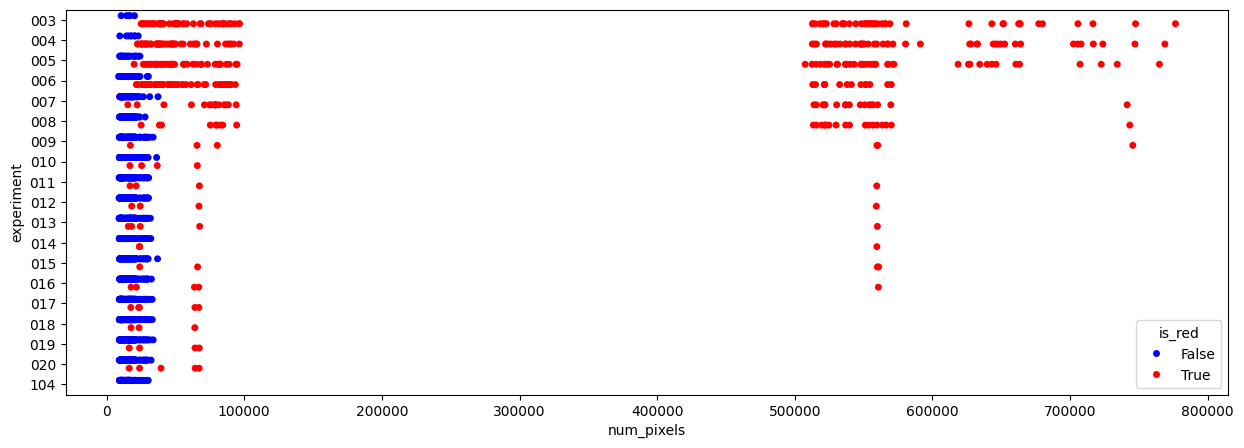

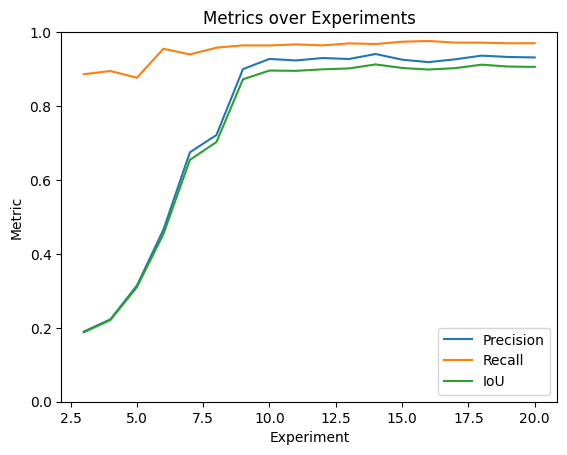

In [5]:
output_path = Path("/media/Data/Data/DavidDylan/experiment_easy_see_through/train")
scene_id = 5
object_id = 11

experiment_metrics_see_through = calc_metrics(output_path, scene_id, object_id)
show_plot(experiment_metrics_see_through, omit_last=True)



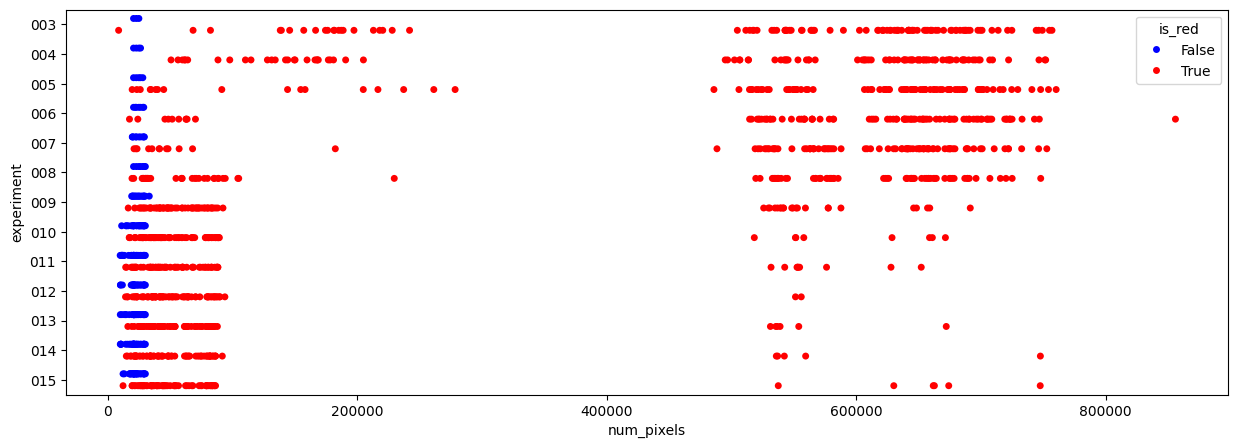

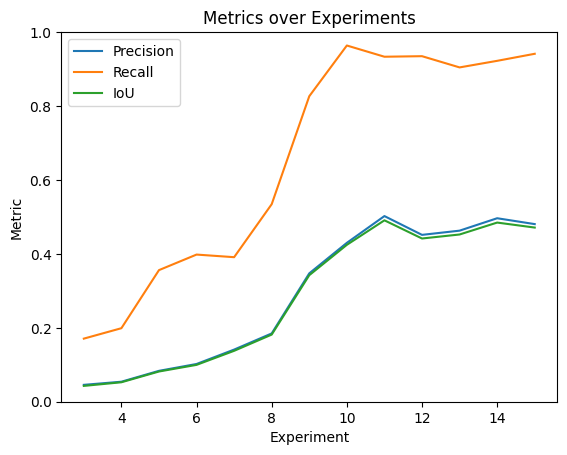

In [6]:
output_path = Path("/media/Data/Data/DavidDylan/experiment_easy_no_ordering_see_through/train")
scene_id = 5
object_id = 11

experiment_metrics_see_through_no_ordering = calc_metrics(output_path, scene_id, object_id)
show_plot(experiment_metrics_see_through_no_ordering)


In [7]:
# ordering_df = pd.Dataframe(experiment_metrics_see_through

SyntaxError: incomplete input (494740372.py, line 1)

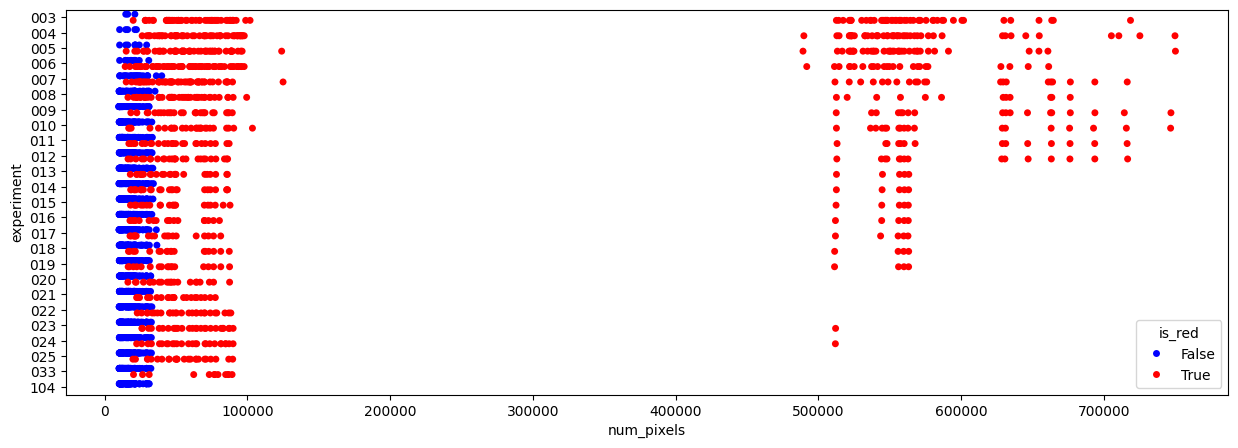

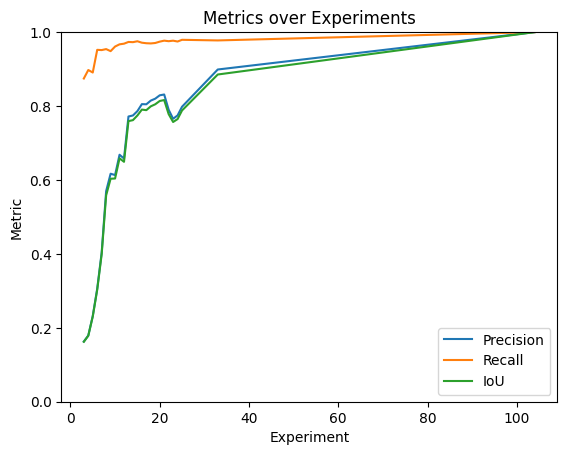

In [8]:
output_path = Path("/media/Data/Data/DavidDylan/experiment_easy_no_background_filtering/train")
scene_id = 5
object_id = 11

experiment_metrics = calc_metrics(output_path, scene_id, object_id)
show_plot(experiment_metrics)



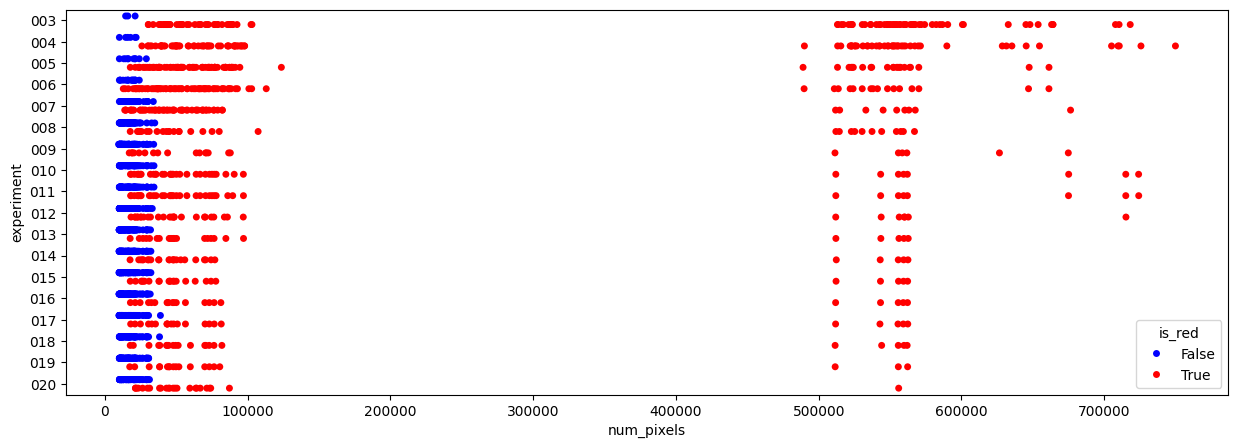

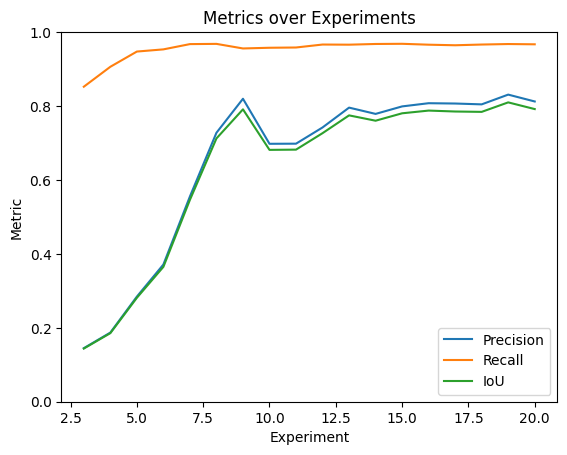

In [9]:
output_path = Path("/media/Data/Data/DavidDylan/experiment_easy_final/train")
scene_id = 5
object_id = 11

experiment_metrics = calc_metrics(output_path, scene_id, object_id, show_images=False)
show_plot(experiment_metrics)

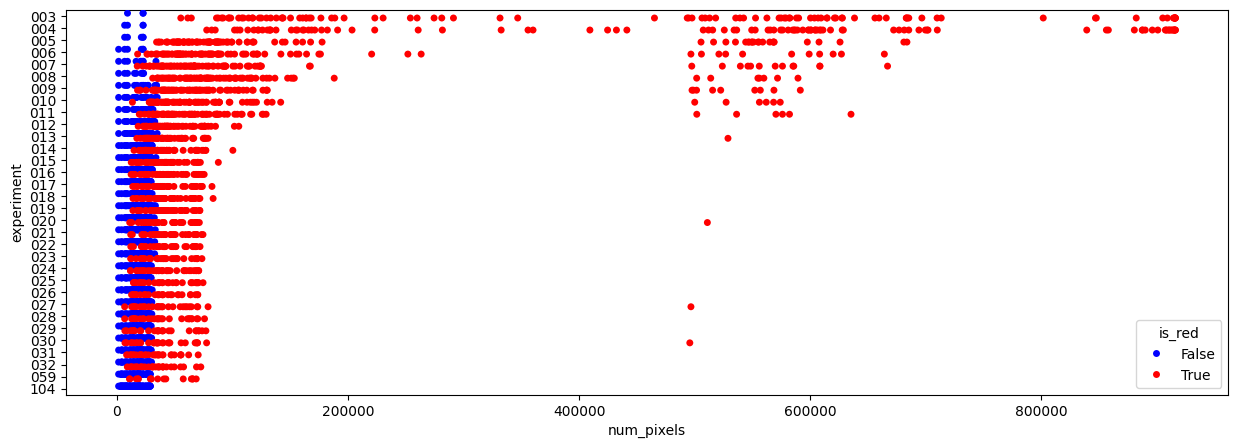

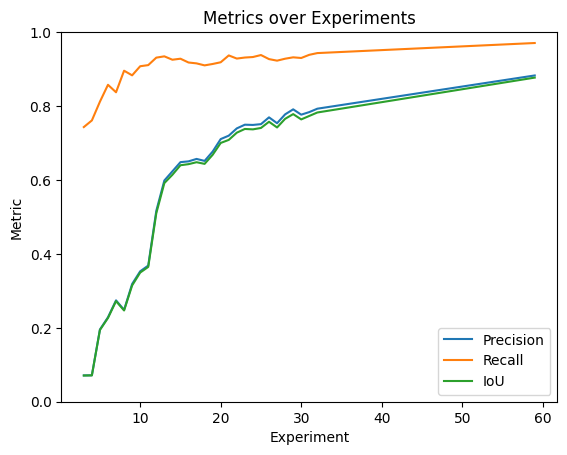

In [ ]:
output_path = Path("/media/Data/Data/DavidDylan/experiment_hard_see_through/train")
scene_id = 1
object_id = 11

experiment_metrics = calc_metrics(output_path, scene_id, object_id, image_index=[11])
show_plot(experiment_metrics, omit_last=True)


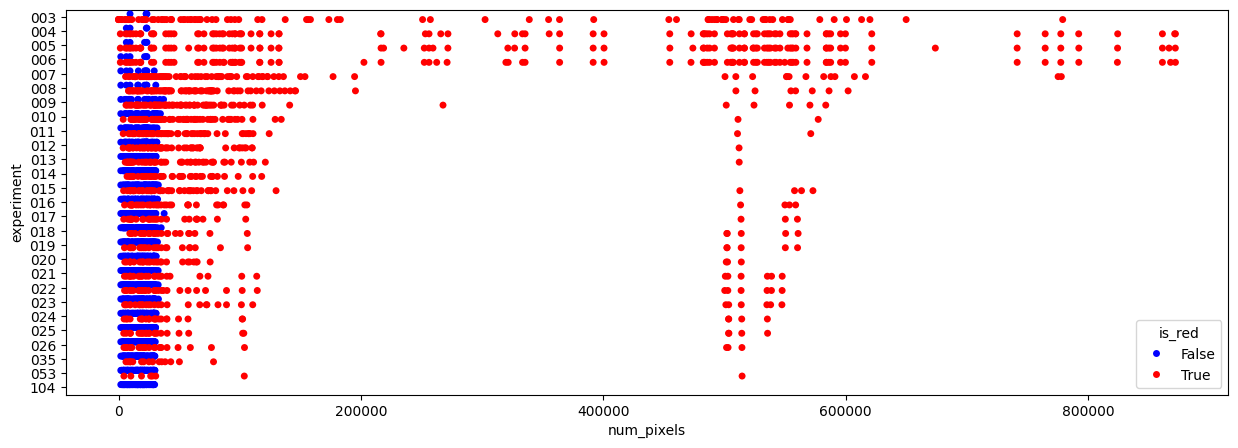

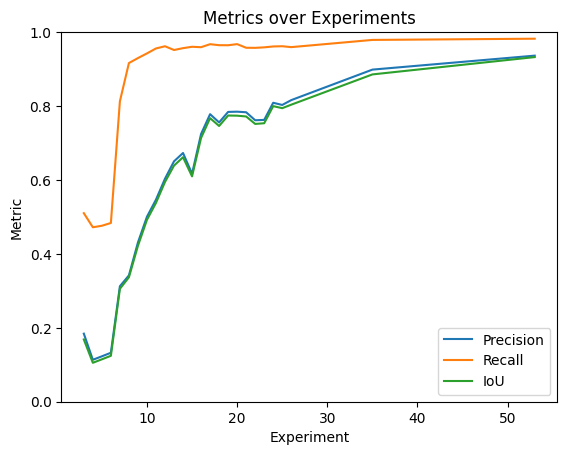

In [ ]:
output_path = Path("/media/Data/Data/DavidDylan/experiment_hard_final/train")
scene_id = 1
object_id = 11

experiment_metrics = calc_metrics(output_path, scene_id, object_id, image_index=[11])
show_plot(experiment_metrics, omit_last=True)
